# Imports and setup

from utils import install_api_key
install_api_key()

In [22]:
# import packages 
import os
import warnings

import numpy as np
import pandas as pd
import xarray as xr
import cftime
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LightSource
import imageio.v2 as imageio
from IPython.display import Video
from tqdm import trange

from pymt.models import Topography, Era5, KuEnhanced
from landlab import RasterModelGrid, imshow_grid
from landlab.components import DepthDependentDiffuser

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 12})

In [2]:
# create folders
study_area = 'alaska'

config_dir = os.path.join(os.getcwd(), 'config_files_{}'.format(study_area))
results_dir = os.path.join(os.getcwd(), 'results_{}'.format(study_area)) 
cache_dir = os.path.join(os.getcwd(),'cache_{}'.format(study_area))


for folder in [config_dir, results_dir, cache_dir]:
    if not os.path.isdir(folder):
        os.mkdir(folder)
        print(folder)

# Download

In [3]:
# initialize Topography data component
dem = Topography()
dem.initialize(os.path.join(config_dir, 'dem_config.yaml'))

/home/egp/dev/mambaforge/envs/pfcase/lib/python3.9/site-packages/bmi_topography/api_key.py:49: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.readthedocs.io/en/latest/#api-key for more information.
  warnings.warn(


In [4]:
# get DEM variable info
var_name = dem.output_var_names[0]
var_unit = dem.var_units(var_name)
var_location = dem.var_location(var_name)
var_type = dem.var_type(var_name)
var_grid = dem.var_grid(var_name)
var_itemsize = dem.var_itemsize(var_name)
var_nbytes = dem.var_nbytes(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: land_surface__elevation 
var_unit: degrees 
var_location: face 
var_type: float32 
var_grid: 0 
var_itemsize: 4
var_nbytes: 331776 



In [5]:
# get DEM grid info 
dem_grid_ndim = dem.grid_ndim(var_grid) 
dem_grid_type = dem.grid_type(var_grid)
dem_grid_shape = dem.grid_shape(var_grid)
dem_grid_spacing = dem.grid_spacing(var_grid)
dem_grid_origin = dem.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    dem_grid_ndim, dem_grid_type, dem_grid_shape, dem_grid_spacing, dem_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [288 288] 
grid_spacing: [ 0.00027778  0.00027778] 
grid_origin: [  63.84027778 -149.28986111]


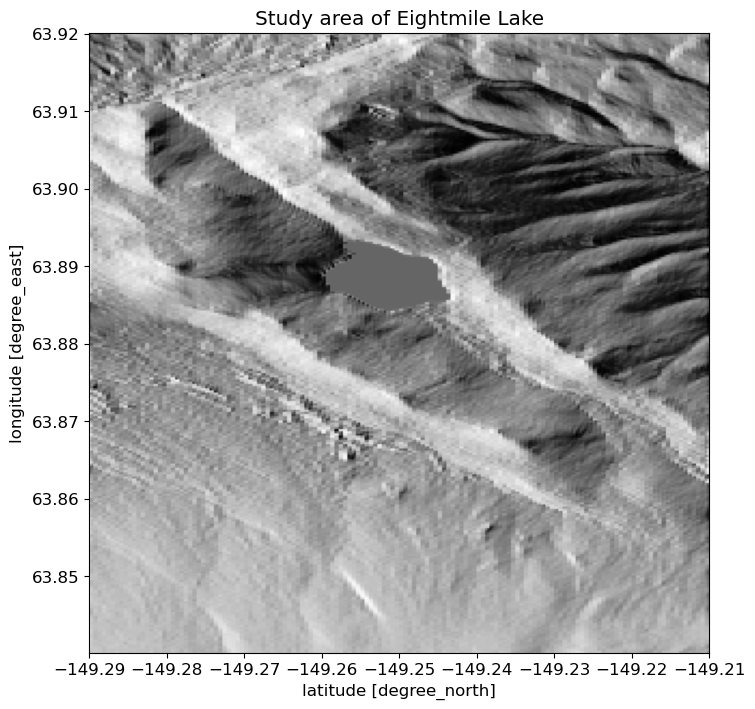

In [6]:
# get DEM variable data
dem_data = dem.get_value(var_name)
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
dem_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data as hillshade plot
fig, ax = plt.subplots(figsize=(8,9))
ls = LightSource(azdeg = 90, altdeg = 30)
shaded_dem = ls.hillshade(np.array(dem_data_2D))

ax.imshow(shaded_dem, cmap = 'Greys',extent=dem_extent)
ax.ticklabel_format(useOffset=False)
ax.set_xlabel('latitude [degree_north]')
ax.set_ylabel('longitude [degree_east]')
ax.title.set_text('Study area of Eightmile Lake')
plt.show()

# ERA5

In [7]:
# initialize ERA5 data components 

# 1980-1989 data
era5 = Era5()
era5.initialize(os.path.join(config_dir,'era5_1980_config.yaml'))

# 2010-2019 data
era5_2 = Era5()
era5_2.initialize(os.path.join(config_dir,'era5_2010_config.yaml'))

In [8]:
# get ERA5 variable info
for var_name in era5.output_var_names:
    var_unit = era5.var_units(var_name)
    var_location = era5.var_location(var_name)
    var_type = era5.var_type(var_name)
    var_grid = era5.var_grid(var_name)
    var_itemsize = era5.var_itemsize(var_name)
    var_nbytes = era5.var_nbytes(var_name)
    print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: 2 metre temperature 
var_unit: K 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 8 

variable_name: Snow density 
var_unit: kg m**-3 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 8 

variable_name: Snow depth 
var_unit: m of water equivalent 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 8 



In [9]:
# get ERA5 grid info
era5_grid_ndim = era5.grid_ndim(var_grid) 
era5_grid_type = era5.grid_type(var_grid)
era5_grid_shape = era5.grid_shape(var_grid)
era5_grid_spacing = era5.grid_spacing(var_grid)
era5_grid_origin = era5.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    era5_grid_ndim, era5_grid_type, era5_grid_shape, era5_grid_spacing, era5_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [2 2] 
grid_spacing: [ 0.25  0.25] 
grid_origin: [  63.66999817 -149.30000305]


In [10]:
# get ERA5 time info
era5_start_time = era5.start_time
era5_end_time = era5.end_time
era5_time_unit = era5.time_units

print('start_time:{} \nend_time:{} \ntime_unit:{}'.format(
    era5_start_time, era5_end_time, era5_time_unit))

start_time:701256.0 
end_time:788184.0 
time_unit:hours since 1900-01-01 00:00:00.0


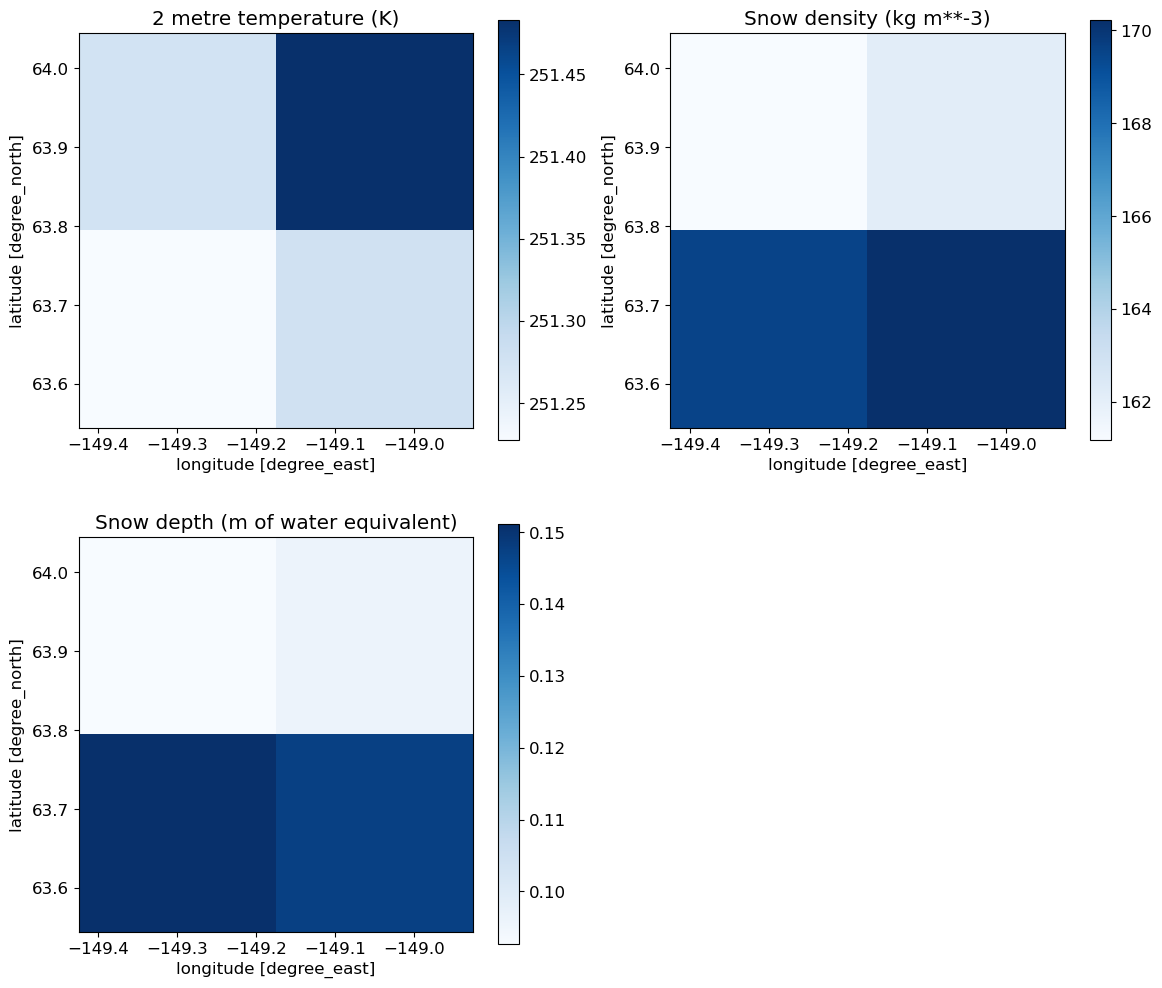

In [11]:
# get ERA5 variables data and plot (at the first time step)
fig = plt.figure(figsize=(14,12)) 
nrows, ncols = 2, 2
i = 1

for var_name in era5.output_var_names:
    ax = fig.add_subplot(nrows, ncols, i)
    var_unit = era5.var_units(var_name)
    
    # get variable data    
    era5_data = era5.get_value(var_name)
    era5_data_2D = era5_data.reshape(era5_grid_shape)
    
    # get X, Y extent for plot
    min_y, min_x = era5_grid_origin
    max_y = min_y + era5_grid_spacing[0]*(era5_grid_shape[0]-1)
    max_x = min_x + era5_grid_spacing[1]*(era5_grid_shape[1]-1)
    dy = era5_grid_spacing[0]/2
    dx = era5_grid_spacing[1]/2
    era5_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

    # plot data
    im = ax.imshow(era5_data_2D, extent=era5_extent, cmap='Blues')
    ax.title.set_text('{} ({})'.format(var_name,var_unit ))
    ax.set_xlabel('longitude [degree_east]')
    ax.set_ylabel('latitude [degree_north]')
    cbar = plt.colorbar(im, ax=ax)
    
    i += 1

In [12]:
# create dataframe to store time series data
era5_df = pd.DataFrame(columns = ['temp','swe','dens','time'])
time_steps = 12*10  # 10 years of monthly data 

for data_comp in [era5, era5_2]:
    
    for i in range(0, time_steps):  
        # get values
        temp = data_comp.get_value('2 metre temperature')
        swe = data_comp.get_value('Snow depth')
        dens = data_comp.get_value('Snow density') 
        time = cftime.num2pydate(data_comp.time, data_comp.time_units)

        # add new row to dataframe
        era5_df.loc[len(era5_df)]=[temp[0], swe[0], dens[0], time]

        # update to next time step
        data_comp.update()
    
era5_df = era5_df.set_index('time') 

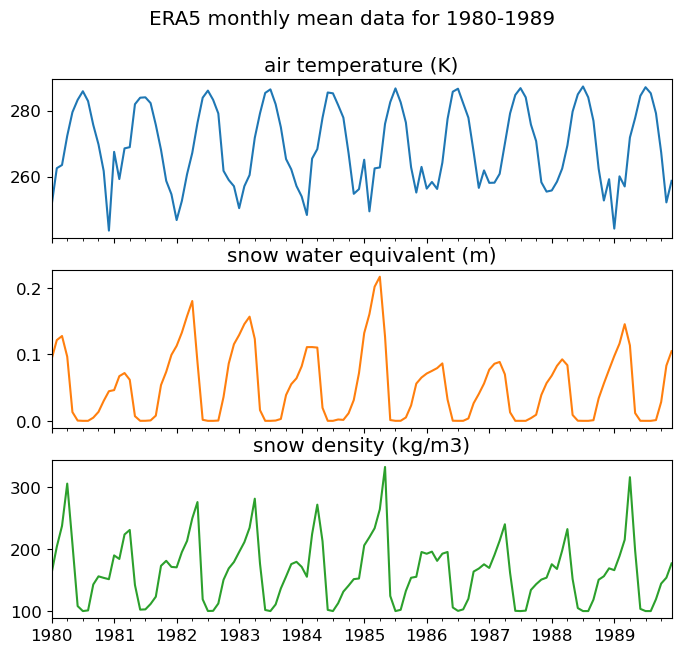

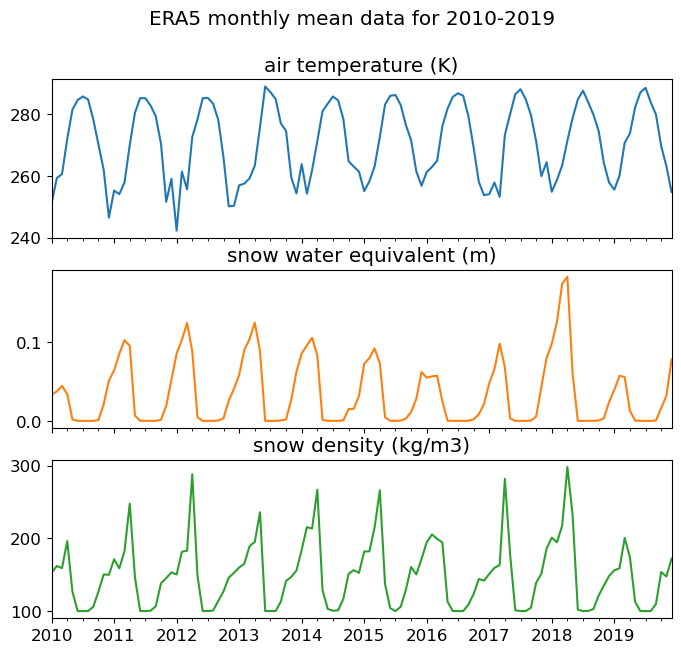

In [13]:
# plot time series data
for start, end in [(1980,1989),(2010,2019)]:
    ax = era5_df[(start<=era5_df.index.year) & (era5_df.index.year<=end)].plot(
        y=['temp','swe','dens'], subplots=True, figsize=(8,7), xlabel='',
        legend=None, title = 'ERA5 monthly mean data for {}-{}'.format(start,end),)
    ax[0].set_title('air temperature (K)')
    ax[1].set_title('snow water equivalent (m)') 
    ax[2].set_title('snow density (kg/m3)')

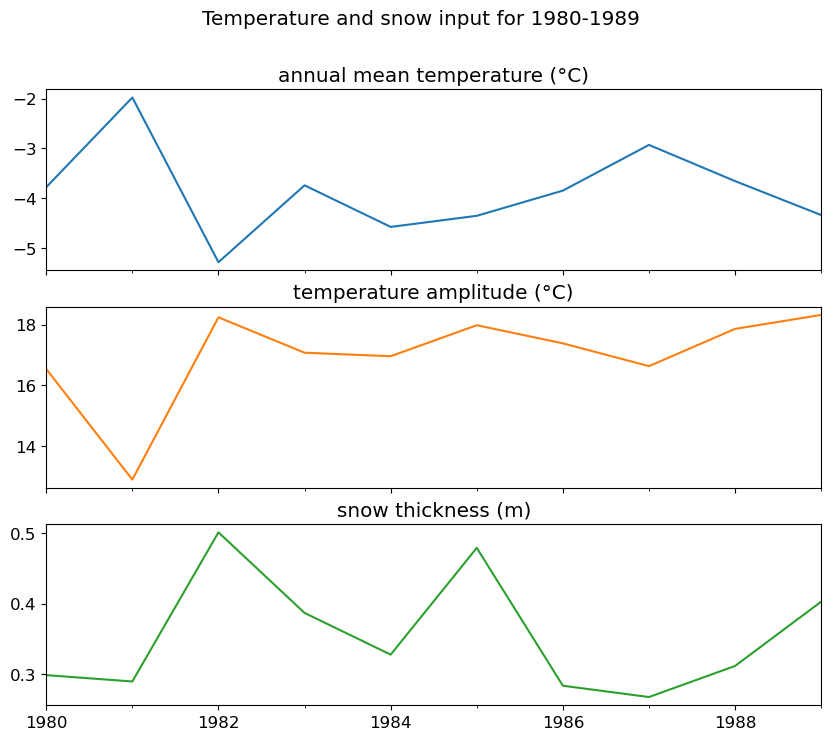

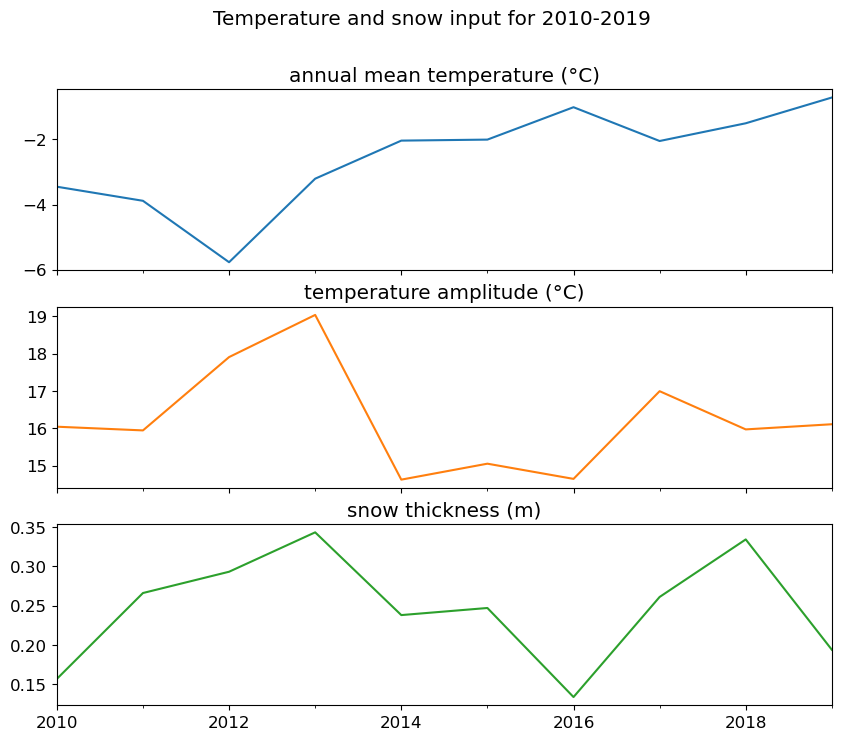

In [14]:
# create a dataframe to store input data
input_df = pd.DataFrame(columns = ['temp_mean','temp_amp', 'snow_h'])

# calculate annual mean temperature and temperature amplitude
input_df['temp_mean'] = era5_df['temp'].groupby(pd.Grouper(freq='Y')).mean() - 273.15
input_df['temp_amp'] = era5_df['temp'].groupby(pd.Grouper(freq='Y')).max() - era5_df['temp'].groupby(pd.Grouper(freq='Y')).mean()

# calculate snow thickness (SWE * water_dens/snow_dens)
water_dens = 1000 # kg/m3
snow_df = era5_df['swe'] * water_dens / era5_df['dens']
snow_df = snow_df[(snow_df.index.month<=5) | (snow_df.index.month>=9)]  # remove summer month
input_df['snow_h'] = snow_df.groupby(pd.Grouper(freq='Y')).mean()

input_df=input_df.round(3).dropna()

# plot the input datasets
for start, end in [(1980,1989),(2010,2019)]:
    ax = input_df[(start<=input_df.index.year) & (input_df.index.year<=end)].plot(
        y=['temp_mean','temp_amp','snow_h'], subplots=True, figsize=(10,8), xlabel='',legend=None, 
        title = 'Temperature and snow input for {}-{}'.format(start,end))
    ax[0].set_title('annual mean temperature (°C)')
    ax[1].set_title('temperature amplitude (°C)') 
    ax[2].set_title('snow thickness (m)')



# KU MODEL

1) Prepare input files
The Ku model configuration file is in cache/Alaska/Ku_example_config.toml. To provide data for each input variable, one can either specify a netCDF file for that variable in the model configuration, set a scalar value, or leave the input variable blank to set dynamically during the model run.

In [101]:
Ku = KuEnhanced()
Ku.initialize('cache_alaska/Ku_example_config.toml')

In [119]:
ku_results = pd.DataFrame(columns = ['active_layer', 'temperature'], index = input_df.index)

for start, end in [(1980,1989), (2010,2019)]:
    print('Simulation for {}-{}'.format(start,end))

    input_data = input_df[(input_df.index.year>=start) & (input_df.index.year<=end)]    

    Ku = KuEnhanced()
    Ku.initialize('cache_alaska/Ku_example_config.toml')

    shape = np.insert(Ku.grid_shape([0]), 0, 10)

    for index, row in input_data.iterrows():
        air_temperature = np.broadcast_to(np.array(row['temp_mean']), Ku.grid_shape(0))
        temp_amplitude = np.broadcast_to(np.array(row['temp_amp']), Ku.grid_shape(0))
        snow_depth = np.broadcast_to(np.array(row['snow_h']), Ku.grid_shape(0))

        Ku.set_value('air_temperature', air_temperature)

        Ku.air_temperature = air_temperature
        Ku.temperature_amplitude = temp_amplitude
        Ku.snow_depth = snow_depth

        Ku.update()

        for var in Ku.get_input_var_names():
            print(var, Ku.get_value(var))

        break

        ku_results.loc[index] = Ku.get_value('active_layer_thickness')[0]
        

Simulation for 1980-1989


ValueError: assignment destination is read-only

In [118]:
Ku.grid_shape(0)

array([3, 3], dtype=int32)